## Goal:

Here we test the functions: `restricted_sinkhorn` and `restricted_greenkhorn` in the `Screenkhorn` class.

In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 

# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

from time import time
# SCREENKHORN
from screenkhorn.screenkhorn_bis import Screenkhorn


## Data generation

In [2]:
n_1 = 1000# nb samples
n_2 = 1000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.7

K = np.exp(-M/reg)

## Sinkhorn 

In [3]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_sink = time() - tic
print("time of Sinkhorn algorithm is %s" %time_sink)

time of Sinkhorn algorithm is 0.029121875762939453


## Restricted Sinkhorn 

#### Bounds of $\varepsilon \in (\varepsilon_{\min}, \varepsilon_{\max})$

\begin{equation}
\label{varepsilon_min}
\varepsilon_{\min} = \min\bigg\{\min_{i}\sqrt{\frac{\mu_i}{\sum_{j}K_{ij}}}, \min_{j}\sqrt{\frac{\nu_j}{\sum_{i}K_{ij}}}\bigg\},
\end{equation}
and 
\begin{align}
	\label{varepsilon_max}
	\varepsilon_{\max} = \max\bigg\{\max_{i}\sqrt{\frac{\mu_i}{\sum_{j}K_{ij}}}, \max_{j}\sqrt{\frac{\nu_j}{\sum_{i}K_{ij}}}\bigg\}.
\end{align}

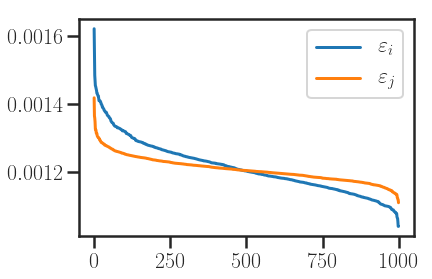

In [4]:
epsilons_a = np.sqrt(a / K.sum(axis=1))
epsilons_a_sort = np.sort(epsilons_a)[::-1]
epsilons_b = np.sqrt(b / K.T.sum(axis=1))
epsilons_b_sort = np.sort(epsilons_b)[::-1]
plt.plot(epsilons_a_sort, label=r'$\varepsilon_i$')
plt.plot(epsilons_b_sort, label=r'$\varepsilon_j$')
plt.legend();

#### Choice of epsilon

In [5]:
epsilons_ab = np.sort(np.hstack([epsilons_a, epsilons_b]))[::-1]
epsilon_mid = (max(epsilons_ab) - min(epsilons_ab))/2 + min(epsilons_ab)
epsilon_min = min(epsilons_ab)
epsilon_max = max(epsilons_ab)

epsilon_min, epsilon_mid, epsilon_max

(0.0010384082990002894, 0.0013295665182757328, 0.0016207247375511762)

#### Initial points and a priori active sets

In [6]:
u0 = np.full(n_1, epsilon_min)
v0 = np.full(n_2, epsilon_min)

I_active = np.where(a >= epsilon_min**2 * K.sum(axis=1))[0].tolist()
J_active = np.where(b >= epsilon_min**2 * K.T.sum(axis=1))[0].tolist()

u0[I_active] = epsilon_min
v0[J_active] = epsilon_min

In [7]:
## Cardinals of I_active and J_active
len(I_active), len(J_active)

(1000, 1000)

In [8]:
## Initialize Screenkhorn class
screenkhorn = Screenkhorn(a, b, M, reg, epsilon_min)

In [9]:
# restricted_sinkhorn
tic = time()
res_sink = screenkhorn.restricted_sinkhorn(u0, v0, I_active, J_active, max_iter=1000, tol=1e-9)
time_res_sink = time() - tic
print("time of Sinkhorn algorithm is %s \n" %time_sink)
print("time of restricted Sinkhorn algorithm is %s \n" %time_res_sink)
print("Ratio between restricted_sinkhorn and sinkhorn is % s" %(time_res_sink/time_sink))

certificate: 8.620135173449999e-34
Certificate is achieved
time of Sinkhorn algorithm is 0.029121875762939453 

time of restricted Sinkhorn algorithm is 0.03715395927429199 

Ratio between restricted_sinkhorn and sinkhorn is 1.2758092774221015


In [10]:
# Comparison of solutions
u_res_sink = res_sink["usc"]
v_res_sink = res_sink["vsc"]

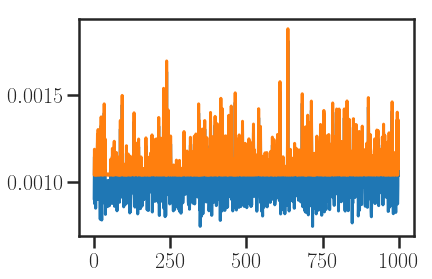

In [11]:
plt.plot(exp_u_star)
plt.plot(u_res_sink)

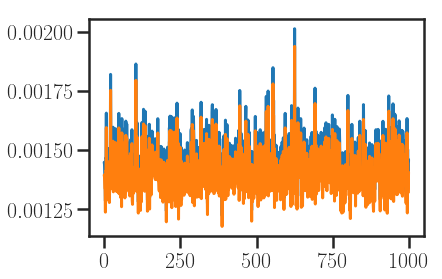

In [12]:
plt.plot(exp_v_star)
plt.plot(v_res_sink)

### Restricted Greenkhorn

In [13]:
tic = time()
greenlike = screenkhorn.restricted_greenkhorn(u0, v0, I_active, J_active, max_iter=1000, tol=1e-9)
time_res_green = time() - tic
print("time of Sinkhorn algorithm is %s \n" %time_sink)
print("time of restricted Sinkhorn algorithm is %s \n" %time_res_sink)
print("time of restricted Greenkhorn algorithm is %s \n" %time_res_green)
print("Ratio between restricted_greenkhorn and sinkhorn is % s" %(time_res_green/time_sink))

time of Sinkhorn algorithm is 0.029121875762939453 

time of restricted Sinkhorn algorithm is 0.03715395927429199 

time of restricted Greenkhorn algorithm is 0.05777287483215332 

Ratio between restricted_greenkhorn and sinkhorn is 1.983830825405662


In [14]:
u_res_green = greenlike["usc"]
v_res_green = greenlike["vsc"]

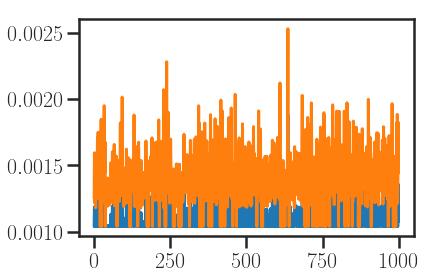

In [15]:
# Same solution given by restricted Sinkhorn and Greenkhorn for u
plt.plot(u_res_sink);
plt.plot(u_res_green);

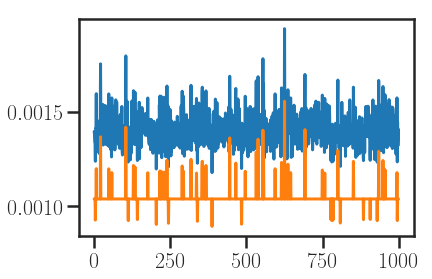

In [16]:
# Same solution given by restricted Sinkhorn and Greenkhorn for v
plt.plot(v_res_sink);
plt.plot(v_res_green);

In [17]:
len(J_active)

1000

In [18]:
epsilon_min

0.0010384082990002894

In [19]:
v_res_green[:10]

array([0.00103841, 0.00103841, 0.00103841, 0.00103841, 0.0009268 ,
       0.00103841, 0.00103841, 0.00119845, 0.00103841, 0.00103841])